# [Paris Saclay Center for Data Science](http://www.datascience-paris-saclay.fr)

## [RAMP](https://www.ramp.studio/problems/pollenating_insects) on Pollinating insect classification

_Mehdi Cherti (CNRS), Romain Julliard (MNHN), Gregoire Lois (MNHN), Balázs Kégl (CNRS)_
    
## Introduction

Pollinating insects play a fundamental role in the stability of ecosystems. An insect is said to be pollinator when it transports pollen from one flower to another, helping them to accomplish fertilization. The vast majority of plants pollinates using insects, and at the same time, these insects depend on plants for their survival. However, because of human intensified agrigulture, urbanisation and climate change, these species are threatened. 35% of human alimentation is based on plants pollinated by insects. Diversity of these insects is also important, the more diverse they are the best overall assistance is provided by these insects.

The [SPIPOLL](http://www.spipoll.org) (Suivi Photographique des Insectes POLLinisateurs) project proposes to quantitatively study pollinating insects in France. For this, they created a crowdsourcing platform where anyone can upload pictures of insects and identify their species through a series of questions. These data are then used by specialists for further analyses.

## Data

In this RAMP, we propose a dataset of pictures of insects from different species gathered from the SPIPOLL project and labeled by specialists. The dataset contains a set of 68815 labeled pictures of insects coming from 209 different insect species. Each picture is a color image. The size of the images (number of pixels) vary.

<table>
<tr>
<td><img src="http://indicia.mnhn.fr/indicia/upload/1442872131301.jpg" height=150></td>
<td><img src="http://indicia.mnhn.fr/indicia/upload/1370973533042.jpg" height=150><td><img src="http://indicia.mnhn.fr/indicia/upload/1402327082359.jpg" height=150></td>
</tr>
<tr>
<td><img src="http://indicia.mnhn.fr/indicia/upload/1379094786054.jpg" height=150></td>
<td><img src="http://indicia.mnhn.fr/indicia/upload/13437683721343768372979.jpg" height=150><td><img src="http://indicia.mnhn.fr/indicia/upload/13118754831311884943109.jpg" height=150></td>
</tr>
<tr>
<td><img src="http://indicia.mnhn.fr/indicia/upload/1371447012469.jpg" height=150></td>
<td><img src="http://indicia.mnhn.fr/indicia/upload/13197014811319713360796.jpg" height=150><td><img src="http://indicia.mnhn.fr/indicia/upload/1344622942134462294226.jpg" height=150></td>
</tr>
</table>

## The prediction task

The goal of this RAMP is to classify correctly the species of the insects. For each submission, you will have to provide an image preprocessor (to standardize, resize, crop, augment images) and batch classifier, which will fit a training set and predict the classes (species) on a test set. The images are big so loading them into the memory at once is impossible. The batch classifier therefore will access them through a generator which can be "asked for" a certain number of training and validation images at a time. You will typically run one minibatch of stochastique gradient descent on these images to train a deep convolutional neural networks which are the state of the art in image classification.

## Hints

First of all, even though 69K images is relatively small compared to industrial level data sets, to achieve state-of-the-art performance, you will need big networks which will take ages (days) to train on a CPU. If you want to have a faster turnaround for tuning your net, you will need a GPU-equipped server of could instance. Setting up an AWS instance is easy, just follow [this tutorial](https://medium.com/@mateuszsieniawski/keras-with-gpu-on-amazon-ec2-a-step-by-step-instruction-4f90364e49ac#.dariq7i2u). If you want to have the starting kit preinstalled, use the community AMI "pollenating_insects_users_".

Your main bottleneck is memory. E.g., increasing the resolution to 128x128, you will need to decrease batch size. You should always run user_test_submission.py on the AWS node before submitting.

For learning the nuts and bolts of convolutional nets, we suggest that you follow [Andrej Karpathy’s excellent course](http://cs231n.github.io).

You have some trivial "classical" options to explore. You should set the epoch size to something more than three (in the starting kit). You should check when the validation error curve flattens because you will also be graded on training and test time. You can change the network architecture, apply different regularization techniques to control overfitting, optimization options to control underfitting.

You can use pretrained nets from [here](https://github.com/fchollet/deep-learning-models). There are a couple of examples in the starting kit. Your options are the following.

* Retrain or not the weights. If you do not, you are using the pretrained net as fixed a feature extractor. You can add some layers on the top of the output of the pretrained net, and only train your layers. If you retrain all the layers, you use the pretrained net as an initialization. Again, your goal is not only to increase accuracy but also to be frugal. Retraining the full net is obviously more expensive.
* You can "read out" the activations from any layer, you do not need to keep the full net, not even the full convolutional stack.
* The starting kit contains examples with the VGG16 net, but feel free to use any of the other popular nets. Just note that there is no way to change the architecture of these nets. In particular, each net expects images of a given dimension so your image preprocessing needs to resize or crop the images to the right size.


You can also adjust the image preprocessing. Resizing to small (64x64 or even 32x32) will make the training faster so you can explore more hyperparameters, but the details will be lost so your final result will probably be suboptimal. Insects are mostly centered in the images but there are a lot of smaller insects which could be cropped for a better performance. You can also rotate the images or apply other data augmentation tricks (google "convolutional nets data augmentation"). You should also look at the actual images to get some inspiration to find meaningful preprocessing ideas.

In [15]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import cm

%matplotlib inline

pd.set_option('display.max_rows', 500)

# The data

If the images are not yet in `data/imgs`, change the type of the net cell to "Code" and run it.

In [16]:
df = pd.read_csv('data/train.csv')
X_df = df['id']
y_df = df['class']
X = X_df.values
y = y_df.values

The class distribution is quite heavy tail: the largest class (ordinary bees) and the three largest classes contain 23% and 42% of the images, respectively.

In [17]:
labels_counts_df = df.groupby('class').count()
labels_counts_df = labels_counts_df.rename(columns={'id': 'count'})
class_codes_df = pd.read_csv('data/class_codes.csv', index_col='class')
labels_counts_df = pd.merge(
    class_codes_df, labels_counts_df, left_index=True, right_index=True)
labels_counts_df = labels_counts_df.sort_values('count', ascending=False)
labels_counts_df

,taxa_name,count
class,,
202,L'Abeille mellifère <Apis mellifera>,4875
159,Les Eristales (autres) <Eristalis>,4079
57,Les Bourdons noirs à bande(s) jaune(s) et cul ...,2489
134,Les Bourdons à pilosité fauve à grise <Bombus>,1660
94,Le Syrphe ceinturé <Episyrphus balteatus>,1442
131,Les Mouches difficiles à déterminer,1310
27,"Les Halictes (femelles) <Halictus, Lasioglossu...",1078
97,Les Oedemères verts <Oedemera>,915
170,"Les Mouches aux reflets métalliques <Neomyia, ...",850


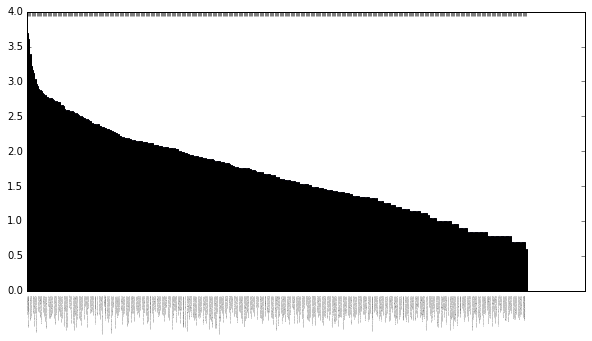

In [18]:
import sys  

reload(sys)  
sys.setdefaultencoding('utf8')

plt.figure(figsize=(10, 5))

x = np.arange(len(labels_counts_df))
plt.bar(x, np.log10(labels_counts_df['count']))
plt.xticks(x + 0.5, labels_counts_df['taxa_name'], rotation=90, fontsize=1);

It is worthwhile to look at some image panels, grouped by label. 

IOError: [Errno 2] No such file or directory: 'data/imgs/2164'

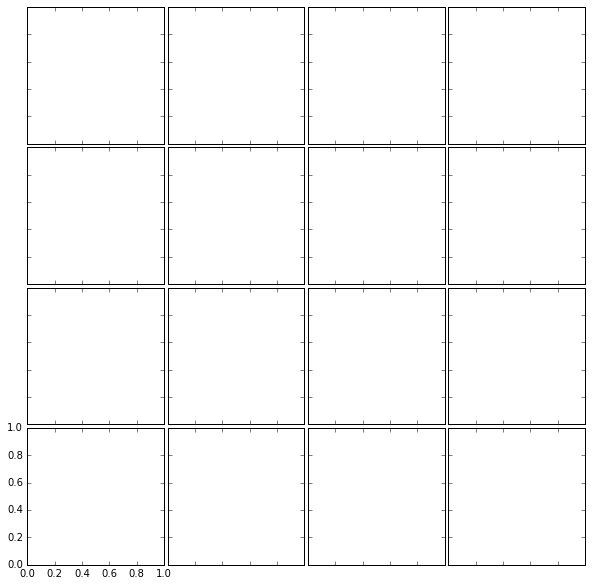

In [19]:
nb_rows = 4
nb_cols = 4
nb_elements = nb_rows * nb_cols
# change the label here to see other classes
label = 1

print("{0}".format(labels_counts_df.loc[label]))

X_given_label = X[y==label]

subsample = np.random.choice(X_given_label, replace=False, size=nb_elements)

fig = plt.figure(figsize=(10, 10))
grid = AxesGrid(fig, 111, # similar to subplot(141)
                nrows_ncols = (nb_rows, nb_cols),
                axes_pad = 0.05,
                label_mode = "1",
)
for i, image_id in enumerate(subsample):
    filename = 'data/imgs/{}'.format(image_id)
    image = imread(filename)
    im = grid[i].imshow(image/255.)
    grid[i].axis('off')
plt.tight_layout()

All images have width 1024, with varying height (40% has 768).

In [21]:
n_subsample = 1000
shapes = np.empty((n_subsample, 3))
for i, image_id in enumerate(X[:n_subsample]):
    filename = 'data/imgs/{}'.format(image_id)
    image = imread(filename)
    shapes[i] = image.shape

In [22]:
shapes_df = pd.DataFrame(shapes,columns=['height', 'width', 'count'])
shapes_df.groupby(['height', 'width']).count().sort_values('count', ascending=False)

,,count
height,width,
768.0,1024.0,418
1365.0,1024.0,104
769.0,1024.0,62
767.0,1024.0,45
770.0,1024.0,39
1364.0,1024.0,22
683.0,1024.0,17
771.0,1024.0,16
1366.0,1024.0,15


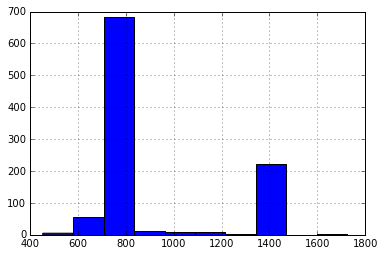

In [23]:
shapes_df['height'].hist();

# Image preprocessing

In the first workflow element `image_preprocessor.py` you can resize, crop, or rotate the images. This is an important step. Neural nets need standard-size images defined by the dimension of the input layer. Larger images can contain more detail but they are heavier on memory and training time. Most insects are in the middle of the image, so cropping can be a good strategy (especially non-standard portrait type photos which may be distorted in the "wrong" way by simply resizing). Data augmentation by careful random transformations (resize, crop, but also rotate) could be another option to explore.

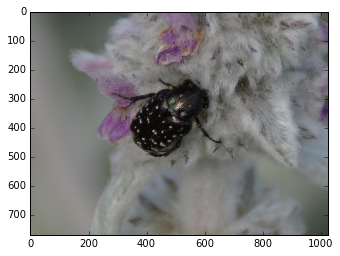

In [25]:
filename = 'data/imgs/{}'.format(X[161])
image = imread(filename)
plt.imshow(image/255.)
plt.show()

Here we resize the images to different resolutions, then blow them up so the difference can be visible.

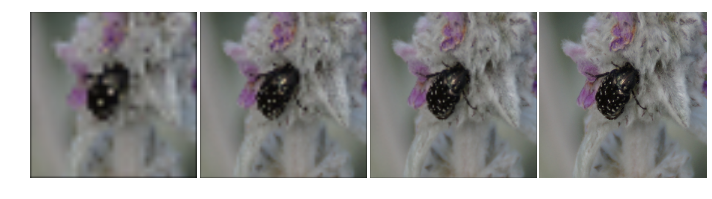

In [26]:
from skimage.transform import resize

nb_rows = 1
nb_cols = 4
nb_elements = nb_rows * nb_cols


fig = plt.figure(figsize=(10, 10))
grid = AxesGrid(fig, 111, # similar to subplot(141)
                nrows_ncols = (nb_rows, nb_cols),
                axes_pad = 0.05,
                label_mode = "1",
)
grid[0].imshow(resize(resize(image, (32, 32), preserve_range=True)/255., (224, 224)))
grid[0].axis('off')
grid[1].imshow(resize(resize(image, (64, 64), preserve_range=True)/255., (224, 224)))
grid[1].axis('off')
grid[2].imshow(resize(resize(image, (128, 128), preserve_range=True)/255., (224, 224)))
grid[2].axis('off')
grid[3].imshow(resize(resize(image, (224, 224), preserve_range=True)/255., (224, 224)))
grid[3].axis('off')
plt.tight_layout()

Here we crop the middle of the image before resizing so there is no distrotion.

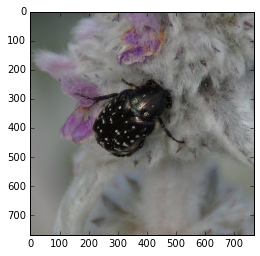

In [27]:
h, w = image.shape[:2]
min_shape = min(h, w)
cropped_image = image[h/2 - min_shape / 2:h/2 + min_shape / 2,
                      w/2 - min_shape / 2:w/2 + min_shape / 2]
plt.imshow(cropped_image/255.)
plt.show()

Here we rotate the image. Explore options in skimage.

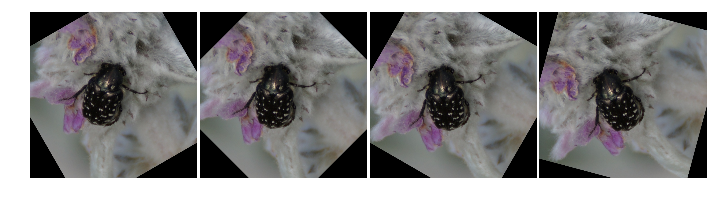

In [28]:
from skimage.transform import rotate

nb_rows = 1
nb_cols = 4
nb_elements = nb_rows * nb_cols

fig = plt.figure(figsize=(10, 10))
grid = AxesGrid(fig, 111, # similar to subplot(141)
                nrows_ncols = (nb_rows, nb_cols),
                axes_pad = 0.05,
                label_mode = "1",
)
grid[0].imshow(rotate(cropped_image, 30, preserve_range=True)/255.)
grid[0].axis('off')
grid[1].imshow(rotate(cropped_image, 45, preserve_range=True)/255.)
grid[1].axis('off')
grid[2].imshow(rotate(cropped_image, 60, preserve_range=True)/255.)
grid[2].axis('off')
grid[3].imshow(rotate(cropped_image, 75, preserve_range=True)/255.)
grid[3].axis('off')
plt.tight_layout()

All these tansformations should be implemented in the `transform` function found in the `image_preprocessor` workflow element that you will submit.

## The pipeline

For submitting at the [RAMP site](http://ramp.studio), you will have to write two classes, saved in two different files:   
* the function `image_preprocessor`, which will be used to transform the images. 
* a class `BatchClassifier` that will handle the training and prediction using sample generators.

Note that the following code cells are *not* executed in the notebook. The notebook saves their contents in the file specified in the first line of the cell, so you can edit your submission before running the local test below and submitting it at the RAMP site.

### Image preprocessor

The starting kit preprocessor crops the middle square of the image, resizes it to $32 \times 32$, brings pixel intensities into the $[0, 1]$ interval, and puts the channel dimension in the first position. Note the safeguard that checks if the number of channels (x.shape[2]) is 4. Normally each image has three (RGB) channels, but some of them also contains an opacity channel which we need to ignore.

In [47]:
%%file submissions/starting_kit/image_preprocessor.py
from skimage.transform import resize


def transform(x):
    if x.shape[2] == 4:
        x = x[:, :, 0:3]
    h, w = x.shape[:2]
    min_shape = min(h, w)
    x = x[h / 2 - min_shape / 2:h / 2 + min_shape / 2,
          w / 2 - min_shape / 2:w / 2 + min_shape / 2]

    x = resize(x, (32, 32), preserve_range=True)
    x = x / 255.
    x = x.transpose((2, 0, 1))
    return x



### The batch classifier

Your convnet models will be implemented in the `batch_classifier.py` workflow element. The model is usually implemented in a separate `build_model` function which is called from `init`. It does not do any computation, just builds the network architecture. Your main task is to find the right architecture for this data set. Every parameter is "free": the size of the input layer (which should match the preprocessing you do in `image_preprocessing.transform`), the number and composition of the convolutional blocks, the size and number of filters in each layer, the number and size of the fully connected layers, the regularization that you apply (usually only on the fully connected layers), and the optimizer. In addition, in the fit function you shold decide the size of the minibatches and the number of epochs. 

The starting kit is using [keras](https://keras.io). In general, image data sets are too big for loading to the memory at once, so instead of a set of images, your `batch_classifier.fit` function will receive a <i>generator</i>. The type of this generator is `BatchGeneratorBuilder` that you can find in [`rampwf.workflows.image_classifier`](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/workflows/image_classifier.py). You will interact with it by calling its `get_train_valid_generators` function. This function will still not return data, since typically you would call the `fit` function of a keras neural net with it, which would again result in filling the memory too fast. Instead, it returns two other generators that you will pass to the `fit_generator` function of a keras model. Why two? The first generator will generate _training_ images for keras, and the second generator generates _validation_ images, which you can use to monitor the learning curves when developing the model. Normally you will not need validation samples in your submission (only when you develop your models outside of the RAMP server) unless you implement automatic early stopping based on validation accuracy.

The `BatchGeneratorBuilder.get_train_valid_generators` function expects two parameters:
* `valid_ratio`: the ratio of the minibatch that should be used for validation, typically 0.1, and
* `batch_size`: the number of images keras' `fit_generator` will get for every minibatch.
The batch size is an important hyperparameter. Statistically, a larger batch size means more precise gradient estimates but computationally slower steps. More importantly, you will have to carefully set the batch size for staying within the memory, depending on the input image size, your network architecture, and your backend. In the starting kit we use 32 images per minibatch. 

In [8]:
%%file submissions/starting_kit/batch_classifier.py
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.optimizers import Adam
from rampwf.workflows.image_classifier import get_nb_minibatches


class BatchClassifier(object):
    def __init__(self):
        self.model = self._build_model()

    def fit(self, gen_builder):
        batch_size = 32
        gen_train, gen_valid, nb_train, nb_valid =\
            gen_builder.get_train_valid_generators(
                batch_size=batch_size, valid_ratio=0.1)
        self.model.fit_generator(
            gen_train,
            # Total number of steps (batches of samples) to yield from
            # generator before declaring one epoch finished and starting the
            # next epoch. It should typically be equal to the number of unique
            # samples of your dataset divided by the batch size.
            steps_per_epoch=get_nb_minibatches(nb_train, batch_size),
            epochs=1,
            # In parallel to training, a CPU process loads and preprocesses
            # data from disk and put it into a queue in the form of
            # mini-batches of size `batch_size`.`max_queue_size` controls the
            # maximum size of that queue. The size of the queue should be big
            # enough so that the training process (GPU) never
            # waits for data (the queue should be never be empty).
            # The CPU process loads chunks of 1024 images each time, and
            # 1024/batch_size mini-batches from that chunk are put into the
            # queue. Assuming training the model on those 1024/batch_size
            # mini-batches is slower than loading a single chunk of 1024
            # images, a good lower bound for `max_queue_size` would be
            # (1024/batch_size). if `batch_size` is 16, you can put
            # `max_queue_size` to 64.
            max_queue_size=16,
            # WARNING : It is obligatory to set `workers` to 1.
            # This in principle controls the number of workers used
            # by keras to load mini-batches from disk to memory in parallel
            # to GPU training. But I don't like the way it works and their
            # code is not very commented/used, so I dont trust it that much
            # (we might have surprises).
            # The way it works in keras is by launching in parallel `workers`
            # threads or processes which will all use a copy of the generator
            # passed to `fit_generator`. So if nothing is done and `workers`
            # is set to some number > 1, the neural net will be trained with
            # repetitions of the same data, because the workers are independent
            # and they got through the same generator.
            # Hence it is necessary to introduce a shared lock between the the
            # processes so that they load different data, this can become a bit
            # complicated, so I choose to rather load exactly one chunk at a
            # time using 1 worker (so `workers` have to be equal to 1), but
            # do this single chunk loading in parallel with joblib.
            workers=1,
            use_multiprocessing=True,
            validation_data=gen_valid,
            validation_steps=get_nb_minibatches(nb_valid, batch_size),
            verbose=1)

    def predict_proba(self, X):
        return self.model.predict(X)

    def _build_model(self):
        inp = Input((3, 32, 32))
        # Block 1
        x = Conv2D(
            32, (3, 3), activation='relu', padding='same',
            name='block1_conv1')(inp)
        x = Conv2D(
            32, (3, 3), activation='relu', padding='same',
            name='block1_conv2')(x)
        x = MaxPooling2D(
            (2, 2), strides=(2, 2),
            name='block1_pool')(x)
        # Block 2
        x = Conv2D(
            64, (3, 3), activation='relu', padding='same',
            name='block2_conv1')(x)
        x = Conv2D(
            64, (3, 3), activation='relu', padding='same',
            name='block2_conv2')(x)
        x = MaxPooling2D(
            (2, 2), strides=(2, 2),
            name='block2_pool')(x)
        # dense
        x = Flatten(
            name='flatten')(x)
        x = Dense(
            512, activation='relu',
            name='fc1')(x)
        out = Dense(
            209, activation='softmax',
            name='predictions')(x)
        model = Model(inp, out)
        model.compile(
            loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
            metrics=['accuracy'])
        return model



## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](/tree/submissions/starting_kit), not on the classes defined in the cells of this notebook.

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `image_preprocessor.py` and `batch_classifier.py` are in the  [`submissions/starting_kit`](/tree/submissions/starting_kit) folder, and the data `train.csv` and `test.csv` are in [`data`](/tree/data). If you haven't yet, downlad the images by executing `python download_data.py`. Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

Note that reasonable models will take a long time to execute on machines with no GPUs. We suggest that you execute the starting kit on, e.g., a GPU-equipped AWS instance. You can set it up by following [this tutorial](https://medium.com/@mateuszsieniawski/keras-with-gpu-on-amazon-ec2-a-step-by-step-instruction-4f90364e49ac#.dariq7i2u).

In [ ]:
!ramp_test_submission

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good feature extractor and classifier, you can submit them to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event [pollenating insects dssp5](http://www.ramp.studio/events/pollenating_insects_dssp5) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/pollenating_insects_dssp5/sandbox) and copy-paste (or upload) [`image_preprocessor.py`](/edit/submissions/starting_kit/image_preprocessor.py) and [`batch_classifier.py`](/edit/submissions/starting_kit/batch_classifier.py) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/pollenating_insects_dssp5/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/pollenating_insects_dssp5/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/pollenating_insects_dssp5/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train accuracy = 0.37 ± 0.0
train nll = 2.22 ± 0.0
valid accuracy = 0.36 ± 0.0
valid nll = 2.22 ± 0.0
test accuracy = 0.36 ± 0.0
test nll = 2.26 ± 0.0
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/pollenating_insects_dssp5/leaderboard)) is accuracy, so the line that is relevant in the output of `ramp_test_submission` is `valid accuracy = 0.36 ± 0.0`. When the score is good enough, you can submit it at the RAMP.

## Other models in the starting kit

You can also keep several other submissions in your work directory [`submissions`](/tree/submissions).

### Keras VGG16

[`keras`](/tree/submissions/keras) uses the same image transformer as [`starting_kit`](/tree/submissions/starting_kit), except it doubles the resolution, and implements the VGG16 architecture.

In [48]:
%%file submissions/keras/image_preprocessor.py
from skimage.transform import resize


def transform(x):
    if x.shape[2] == 4:
        x = x[:, :, 0:3]
    h, w = x.shape[:2]
    min_shape = min(h, w)
    x = x[h / 2 - min_shape / 2:h / 2 + min_shape / 2,
          w / 2 - min_shape / 2:w / 2 + min_shape / 2]

    x = resize(x, (64, 64), preserve_range=True)
    x = x / 255.
    x = x.transpose((2, 0, 1))
    return x



In [9]:
%%file submissions/keras/batch_classifier.py
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.optimizers import Adam
from rampwf.workflows.image_classifier import get_nb_minibatches


class BatchClassifier(object):
    def __init__(self):
        self.model = self._build_model()

    def fit(self, gen_builder):
        batch_size = 32
        gen_train, gen_valid, nb_train, nb_valid =\
            gen_builder.get_train_valid_generators(
                batch_size=batch_size, valid_ratio=0.1)
        self.model.fit_generator(
            gen_train,
            steps_per_epoch=get_nb_minibatches(nb_train, batch_size),
            epochs=1,
            max_queue_size=16,
            workers=1,
            use_multiprocessing=True,
            validation_data=gen_valid,
            validation_steps=get_nb_minibatches(nb_valid, batch_size),
            verbose=1)

    def predict_proba(self, X):
        return self.model.predict(X)

    def _build_model(self):
        # This is VGG16
        inp = Input((3, 64, 64))
        # Block 1
        x = Conv2D(
            64, (3, 3), activation='relu', padding='same',
            name='block1_conv1')(inp)
        x = Conv2D(
            64, (3, 3), activation='relu', padding='same',
            name='block1_conv2')(x)
        x = MaxPooling2D(
            (2, 2), strides=(2, 2),
            name='block1_pool')(x)
        # Block 2
        x = Conv2D(
            128, (3, 3), activation='relu', padding='same',
            name='block2_conv1')(x)
        x = Conv2D(
            128, (3, 3), activation='relu', padding='same',
            name='block2_conv2')(x)
        x = MaxPooling2D(
            (2, 2), strides=(2, 2),
            name='block2_pool')(x)
        # Block 3
        x = Conv2D(
            256, (3, 3), activation='relu', padding='same',
            name='block3_conv1')(x)
        x = Conv2D(
            256, (3, 3), activation='relu', padding='same',
            name='block3_conv2')(x)
        x = Conv2D(
            256, (3, 3), activation='relu', padding='same',
            name='block3_conv4')(x)
        x = MaxPooling2D(
            (2, 2), strides=(2, 2),
            name='block3_pool')(x)
        # Block 4
        x = Conv2D(
            512, (3, 3), activation='relu', padding='same',
            name='block4_conv1')(x)
        x = Conv2D(
            512, (3, 3), activation='relu', padding='same',
            name='block4_conv3')(x)
        x = Conv2D(
            512, (3, 3), activation='relu', padding='same',
            name='block4_conv4')(x)
        x = MaxPooling2D(
            (2, 2), strides=(2, 2),
            name='block4_pool')(x)
        # Block 5
        x = Conv2D(
            512, (3, 3), activation='relu', padding='same',
            name='block5_conv1')(x)
        x = Conv2D(
            512, (3, 3), activation='relu', padding='same',
            name='block5_conv3')(x)
        x = Conv2D(
            512, (3, 3), activation='relu', padding='same',
            name='block5_conv4')(x)
        x = MaxPooling2D(
            (2, 2), strides=(2, 2),
            name='block5_pool')(x)
        # dense
        x = Flatten(name='flatten')(x)
        x = Dense(
            4096, activation='relu',
            name='fc1')(x)
        x = Dense(
            4096, activation='relu',
            name='fc2')(x)
        out = Dense(
            209, activation='softmax',
            name='predictions')(x)
        model = Model(inp, out)
        model.compile(
            loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
            metrics=['accuracy'])
        return model



You can train this by specifying the subfolder in the test script.

In [49]:
!ramp_test_submission --submission keras

### PyTorch

The following submission implements the same VGG architeacture but using the PyTorch library.

In [50]:
%%file submissions/pytorch/image_preprocessor.py
from skimage.transform import resize


def transform(x):
    if x.shape[2] == 4:
        x = x[:, :, 0:3]
    h, w = x.shape[:2]
    min_shape = min(h, w)
    x = x[h / 2 - min_shape / 2:h / 2 + min_shape / 2,
          w / 2 - min_shape / 2:w / 2 + min_shape / 2]

    x = resize(x, (64, 64), preserve_range=True)
    x /= 255.
    x = x.transpose((2, 0, 1))
    return x


In [10]:
%%file submissions/pytorch/batch_classifier.py
from __future__ import division
import time
from itertools import islice
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from rampwf.workflows.image_classifier import get_nb_minibatches


class BatchClassifier(object):
    def __init__(self):
        self.net = Net()

    def fit(self, gen_builder):
        batch_size = 16
        nb_epochs = 10
        lr = 1e-4

        gen_train, gen_valid, nb_train, nb_valid =\
            gen_builder.get_train_valid_generators(
                batch_size=batch_size, valid_ratio=0.1)
        self.net = self.net.cuda()
        net = self.net
        optimizer = optim.Adam(net.parameters(), lr=lr)
        nb_train_minibatches = get_nb_minibatches(nb_train, batch_size)
        nb_valid_minibatches = get_nb_minibatches(nb_valid, batch_size)
        criterion = nn.CrossEntropyLoss().cuda()

        for epoch in range(nb_epochs):
            t0 = time.time()
            net.train()  # train mode
            nb_trained = 0
            nb_updates = 0
            train_loss = []
            train_acc = []
            for X, y in islice(gen_train, nb_train_minibatches):
                # convert onehot to integers, pytorch require the class indices
                y = y.argmax(axis=1)
                X = _make_variable(X)
                y = _make_variable(y)
                # zero-out the gradients because they accumulate by default
                optimizer.zero_grad()
                y_pred = net(X)
                loss = criterion(y_pred, y)
                loss.backward()  # compute gradients
                optimizer.step()  # update params

                # Loss and accuracy
                train_acc.extend(self._get_acc(y_pred, y))
                train_loss.append(loss.data[0])
                nb_trained += X.size(0)
                nb_updates += 1
                if nb_updates % 100 == 0 or nb_updates == nb_train_minibatches:
                    print(
                        'Epoch [{}/{}], [trained {}/{}], avg_loss: {:.4f}'
                        ', avg_train_acc: {:.4f}'.format(
                            epoch + 1, nb_epochs, nb_trained, nb_train,
                            np.mean(train_loss), np.mean(train_acc)))

            net.eval()  # eval mode
            nb_valid = 0
            valid_acc = []
            for X, y in islice(gen_valid, nb_valid_minibatches):
                y = y.argmax(axis=1)
                X = _make_variable(X)
                y = _make_variable(y)
                y_pred = net(X)
                valid_acc.extend(self._get_acc(y_pred, y))
                nb_valid += y.size(0)

            delta_t = time.time() - t0
            print('Finished epoch {}'.format(epoch + 1))
            print('Time spent : {:.4f}'.format(delta_t))
            print('Train acc : {:.4f}'.format(np.mean(train_acc)))
            print('Valid acc : {:.4f}'.format(np.mean(valid_acc)))

    def _get_acc(self, y_pred, y_true):
        y_pred = y_pred.cpu().data.numpy().argmax(axis=1)
        y_true = y_true.cpu().data.numpy()
        return (y_pred == y_true)

    def predict_proba(self, X):
        X = X.astype(np.float32)
        X = _make_variable(X)
        y_proba = nn.Softmax()(self.net(X)).cpu().data.numpy()
        return y_proba


def _make_variable(X):
    return Variable(torch.from_numpy(X)).cuda()


class Net(nn.Module):
    def __init__(self, w=64, h=64):
        super(Net, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        nb_blocks = 5
        w_final = w // (2 ** nb_blocks)
        h_final = h // (2 ** nb_blocks)
        self.fc = nn.Sequential(
            nn.Linear(512 * w_final * h_final, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 209),
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = _flatten(x)
        x = self.fc(x)
        return x

    def _initialize_weights(self):
        # Source: https://github.com/pytorch/vision/blob/master/torchvision/
        # models/vgg.py
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def _flatten(x):
    return x.view(x.size(0), -1)



In [52]:
!ramp_test_submission --submission pytorch

## Pretrained nets

In our experience, with the moderate data size we have in this challenge, the best performance is achieved with pretrained nets. When you use a pretrained net, you are copying not only the architecture but also the weights that were saved after training the net, usually on ImageNet. You have some options. 
1. `include_top` means that you also copy the fully connected net from the pretrained net. Usually we do not do that, rather design and train our fully connected layer on top of the last convolutional layer.
2. `trainable` means that you retrain also the convolutional weights. If set to `True`, it means that you use the pretrained net as an initializer; `False` means you use the pretrained net as a fixed feature extractor.

Note that when you use a pretrained net, the image size must match the size that was used to train the net. In current ImageNet classifiers this is rather large (e.g., 224 x 224) which means that you need to decrease the batch size not to crash the GPU memory.

### Keras pretrained

The following submission uses the VGG16 architecture, pretrained on ImageNet.

In [54]:
%%file submissions/keras_pretrained/image_preprocessor.py
from skimage.transform import resize


def transform(x):
    if x.shape[2] == 4:
        x = x[:, :, 0:3]
    h, w = x.shape[:2]
    min_shape = min(h, w)
    x = x[h / 2 - min_shape / 2:h / 2 + min_shape / 2,
          w / 2 - min_shape / 2:w / 2 + min_shape / 2]

    x = resize(x, (224, 224), preserve_range=True)
    x = x.transpose((2, 0, 1))
    # 'RGB'->'BGR'
    x = x[::-1, :, :]
    # Zero-center by mean pixel
    x[0, :, :] -= 103.939
    x[1, :, :] -= 116.779
    x[2, :, :] -= 123.68
    return x



In [11]:
%%file submissions/keras_pretrained/batch_classifier.py
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
from rampwf.workflows.image_classifier import get_nb_minibatches


class BatchClassifier(object):
    def __init__(self):
        self.model = self._build_model()

    def fit(self, gen_builder):
        batch_size = 16
        gen_train, gen_valid, nb_train, nb_valid =\
            gen_builder.get_train_valid_generators(
                batch_size=batch_size, valid_ratio=0.1)
        self.model.fit_generator(
            gen_train,
            steps_per_epoch=get_nb_minibatches(nb_train, batch_size),
            epochs=1,
            max_queue_size=16,
            workers=1,
            use_multiprocessing=True,
            validation_data=gen_valid,
            validation_steps=get_nb_minibatches(nb_valid, batch_size),
            verbose=1)

    def predict_proba(self, X):
        return self.model.predict(X)

    def _build_model(self):
        vgg16 = VGG16(include_top=False, weights='imagenet')
        # vgg16.trainable = False
        inp = Input((3, 224, 224))
        x = vgg16(inp)
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        out = Dense(209, activation='softmax', name='predictions')(x)
        model = Model(inp, out)
        model.compile(
            loss='categorical_crossentropy', optimizer=SGD(lr=1e-4),
            metrics=['accuracy'])
        return model



In [ ]:
!ramp_test_submission --submission keras_pretrained

### Pretrained with intermediate layer

When using pretrained models, you can choose to read out the activations from any internediate layer, and complete the net with trained layers. This submission uses the activations from the third convolutional layer of the third block of the VGG16 net and then adds a trainable dense layer.

In [56]:
%%file submissions/keras_pretrained_interm/image_preprocessor.py
from skimage.transform import resize


def transform(x):
    if x.shape[2] == 4:
        x = x[:, :, 0:3]
    h, w = x.shape[:2]
    min_shape = min(h, w)
    x = x[h / 2 - min_shape / 2:h / 2 + min_shape / 2,
          w / 2 - min_shape / 2:w / 2 + min_shape / 2]

    x = resize(x, (224, 224), preserve_range=True)
    x = x.transpose((2, 0, 1))
    # 'RGB'->'BGR'
    x = x[::-1, :, :]
    # Zero-center by mean pixel
    x[0, :, :] -= 103.939
    x[1, :, :] -= 116.779
    x[2, :, :] -= 123.68
    return x



In [12]:
%%file submissions/keras_pretrained_interm/batch_classifier.py
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
from rampwf.workflows.image_classifier import get_nb_minibatches


class BatchClassifier(object):
    def __init__(self):
        self.model = self._build_model()

    def fit(self, gen_builder):
        batch_size = 16
        gen_train, gen_valid, nb_train, nb_valid =\
            gen_builder.get_train_valid_generators(
                batch_size=batch_size, valid_ratio=0.1)
        self.model.fit_generator(
            gen_train,
            steps_per_epoch=get_nb_minibatches(nb_train, batch_size),
            epochs=1,
            max_queue_size=16,
            workers=1,
            use_multiprocessing=True,
            validation_data=gen_valid,
            validation_steps=get_nb_minibatches(nb_valid, batch_size),
            verbose=1)

    def predict_proba(self, X):
        return self.model.predict(X)

    def _build_model(self):
        vgg16 = VGG16(include_top=False, weights='imagenet')
        vgg16.trainable = False
        inp = vgg16.get_layer(name='input_1')
        hid = vgg16.get_layer(name='block3_conv3')
        vgg16_hid = Model(inp.input, hid.output)

        inp = Input((3, 224, 224))
        x = vgg16_hid(inp)
        x = Flatten(name='flatten')(x)
        x = Dense(500, activation='relu', name='fc')(x)
        out = Dense(209, activation='softmax', name='predictions')(x)
        model = Model(inp, out)
        model.compile(
            loss='categorical_crossentropy',
            optimizer=SGD(lr=1e-4, momentum=0.95), metrics=['accuracy'])
        return model



In [ ]:
!ramp_test_submission --submission keras_pretrained_interm

### PyTorch pretrained

The last example is a PyTorch model that uses the pretrained VGG net.

In [58]:
%%file submissions/pytorch_pretrained/image_preprocessor.py
from skimage.transform import resize


def transform(x):
    if x.shape[2] == 4:
        x = x[:, :, 0:3]
    h, w = x.shape[:2]
    min_shape = min(h, w)
    x = x[h / 2 - min_shape / 2:h / 2 + min_shape / 2,
          w / 2 - min_shape / 2:w / 2 + min_shape / 2]

    x = resize(x, (224, 224), preserve_range=True)
    x = x.transpose((2, 0, 1))
    # using preprocessing from torchvision:
    # https://github.com/pytorch/examples/blob/master/imagenet/main.py
    x /= 255.
    x[0, :, :] -= 0.485
    x[0, :, :] /= 0.229
    x[1, :, :] -= 0.456
    x[1, :, :] /= 0.224
    x[2, :, :] -= 0.406
    x[2, :, :] /= 0.225
    return x



In [13]:
%%file submissions/pytorch_pretrained/batch_classifier.py
from __future__ import division
import time
from itertools import islice
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision.models.vgg import vgg16
from rampwf.workflows.image_classifier import get_nb_minibatches


class BatchClassifier(object):
    def __init__(self):
        self.net = Net()

    def fit(self, gen_builder):
        batch_size = 16
        nb_epochs = 10
        lr = 1e-4

        gen_train, gen_valid, nb_train, nb_valid =\
            gen_builder.get_train_valid_generators(
                batch_size=batch_size, valid_ratio=0.1)
        self.net = self.net.cuda()
        net = self.net
        optimizer = optim.Adam(net.parameters(), lr=lr)
        nb_train_minibatches = get_nb_minibatches(nb_train, batch_size)
        nb_valid_minibatches = get_nb_minibatches(nb_valid, batch_size)
        criterion = nn.CrossEntropyLoss().cuda()

        for epoch in range(nb_epochs):
            t0 = time.time()
            net.train()  # train mode
            nb_trained = 0
            nb_updates = 0
            train_loss = []
            train_acc = []
            for X, y in islice(gen_train, nb_train_minibatches):
                # convert onehot to integers, pytorch require the class indices
                y = y.argmax(axis=1)
                X = _make_variable(X)
                y = _make_variable(y)
                # zero-out the gradients because they accumulate by default
                optimizer.zero_grad()
                y_pred = net(X)
                loss = criterion(y_pred, y)
                loss.backward()  # compute gradients
                optimizer.step()  # update params

                # Loss and accuracy
                train_acc.extend(self._get_acc(y_pred, y))
                train_loss.append(loss.data[0])
                nb_trained += X.size(0)
                nb_updates += 1
                if nb_updates % 100 == 0 or nb_updates == nb_train_minibatches:
                    print(
                        'Epoch [{}/{}], [trained {}/{}], avg_loss: {:.4f}'
                        ', avg_train_acc: {:.4f}'.format(
                            epoch + 1, nb_epochs, nb_trained, nb_train,
                            np.mean(train_loss), np.mean(train_acc)))

            net.eval()  # eval mode
            nb_valid = 0
            valid_acc = []
            for X, y in islice(gen_valid, nb_valid_minibatches):
                y = y.argmax(axis=1)
                X = _make_variable(X)
                y = _make_variable(y)
                y_pred = net(X)
                valid_acc.extend(self._get_acc(y_pred, y))
                nb_valid += y.size(0)

            delta_t = time.time() - t0
            print('Finished epoch {}'.format(epoch + 1))
            print('Time spent : {:.4f}'.format(delta_t))
            print('Train acc : {:.4f}'.format(np.mean(train_acc)))
            print('Valid acc : {:.4f}'.format(np.mean(valid_acc)))

    def _get_acc(self, y_pred, y_true):
        y_pred = y_pred.cpu().data.numpy().argmax(axis=1)
        y_true = y_true.cpu().data.numpy()
        return (y_pred == y_true)

    def predict_proba(self, X):
        X = X.astype(np.float32)
        X = _make_variable(X)
        y_proba = nn.Softmax()(self.net(X)).cpu().data.numpy()
        return y_proba


def _make_variable(X):
    return Variable(torch.from_numpy(X)).cuda()


class Net(nn.Module):
    def __init__(self, pretrained=True):
        super(Net, self).__init__()
        self.features = vgg16(pretrained=True).features
        self.fc = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(True),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(True),
            nn.Linear(4096, 209),
        )

    def forward(self, x):
        x = self.features(x)
        x = _flatten(x)
        x = self.fc(x)
        return x


def _flatten(x):
    return x.view(x.size(0), -1)



In [60]:
!ramp_test_submission --submission pytorch_pretrained

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=pollenating insects notebook).